# Preprocessing and Exploratory Data Analysis
#### FOUNDATION OF DEEP LEARNING

*Master Degree in Data Science* <br>
*University of Milano-Bicocca* <br> <br> 

Filippo Algeri, Marta Brasola, Maurizio Papa

In [1]:
#ignore warnings
import warnings
import time 
warnings.filterwarnings("ignore", category= UserWarning)

import numpy as np
import pandas as pd 
import json

#Splitting
from sklearn.model_selection import train_test_split

#Undersampling
from imblearn.under_sampling import RandomUnderSampler

##plots
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

#TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

#Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

#download csv
from IPython.display import FileLink

## Import Data

In [2]:
# importing just the columns that we are interested in to accelerate the importing phase 
start_time = time.time()
cols = ['categories', 'abstract', 'title']
data = []
file_name = '/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json'

with open(file_name, encoding='latin-1') as f:
    for line in f:
        doc = json.loads(line)
        lst = [doc['categories'], doc['abstract'], doc['title']]
        data.append(lst)

df = pd.DataFrame(data=data, columns=cols)
print("--- %s seconds ---" % (time.time() - start_time))

--- 94.05975389480591 seconds ---


In [3]:
df.head()

,categories,abstract,title
0,hep-ph,A fully differential calculation in perturba...,Calculation of prompt diphoton production cros...
1,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...",Sparsity-certifying Graph Decompositions
2,physics.gen-ph,The evolution of Earth-Moon system is descri...,The evolution of the Earth-Moon system based o...
3,math.CO,We show that a determinant of Stirling cycle...,A determinant of Stirling cycle numbers counts...
4,math.CA math.FA,In this paper we show how to compute the $\L...,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...


In [4]:
df.shape

(2276611, 3)

## Map the categories 

Based on the official  [arxiv taxonomy](https://arxiv.org/category_taxonomy) we decided to keep just the main 8 categories of the dataset: Physics, Mathematics, Computer Science, Economics, Mathematics, Electrical Engineering and Systems Science, Economics, Quantitative Finance, Quantitative Biology, Statistics. The dictionary *category map*  contains the conversion of the category id to category name that will be useful for a better understaing of the dataset and to check for correct use of the regex. 
To extract the categories of of the dataset we used 3 rounds of regex:
1. to split the words on the space
2. to extract the primary domain before the point
3. to refine the previous regex because of some patterns that were not considered before

In [5]:
category_map = {'astro-ph': 'Physics',
'cond-mat': 'Electrical Engineering and Systems Science',
'cs': 'Computer Science',
'econ': 'Economics',
'eess': 'Physics',
'gr-qc': 'Physics',
'hep-ex': 'Physics',
'hep-lat': 'Physics',
'hep-ph': 'Physics',
'hep-th': 'Physics',
'math': 'Mathematics',
'nlin': 'Physics',
'nucl-ex': 'Physics',
'nucl-th': 'Physics',
'physics': 'Physics',
'q-bio': 'Quantitative Biology',
'q-fin': 'Quantitative Finance',
'quant-ph': 'Physics',
'stat': 'Statistics',
'math-ph': 'Physics'}

In [6]:
# function that returns the primary category of each paper
def extract_major_categories(df):
    df['category'] = df.categories.str.extract(r'^([^ ]+)')
    df['category'] = df.category.str.split(r'\.').str[0]
    return df.category


def map_category(df):
    df['mapped_categories'] = df['category'].map(category_map)
    return df.mapped_categories

In [7]:
y = extract_major_categories(df)
mapped = map_category(df)

In [8]:
df.head()

,categories,abstract,title,category,mapped_categories
0,hep-ph,A fully differential calculation in perturba...,Calculation of prompt diphoton production cros...,hep-ph,Physics
1,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...",Sparsity-certifying Graph Decompositions,math,Mathematics
2,physics.gen-ph,The evolution of Earth-Moon system is descri...,The evolution of the Earth-Moon system based o...,physics,Physics
3,math.CO,We show that a determinant of Stirling cycle...,A determinant of Stirling cycle numbers counts...,math,Mathematics
4,math.CA math.FA,In this paper we show how to compute the $\L...,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math,Mathematics


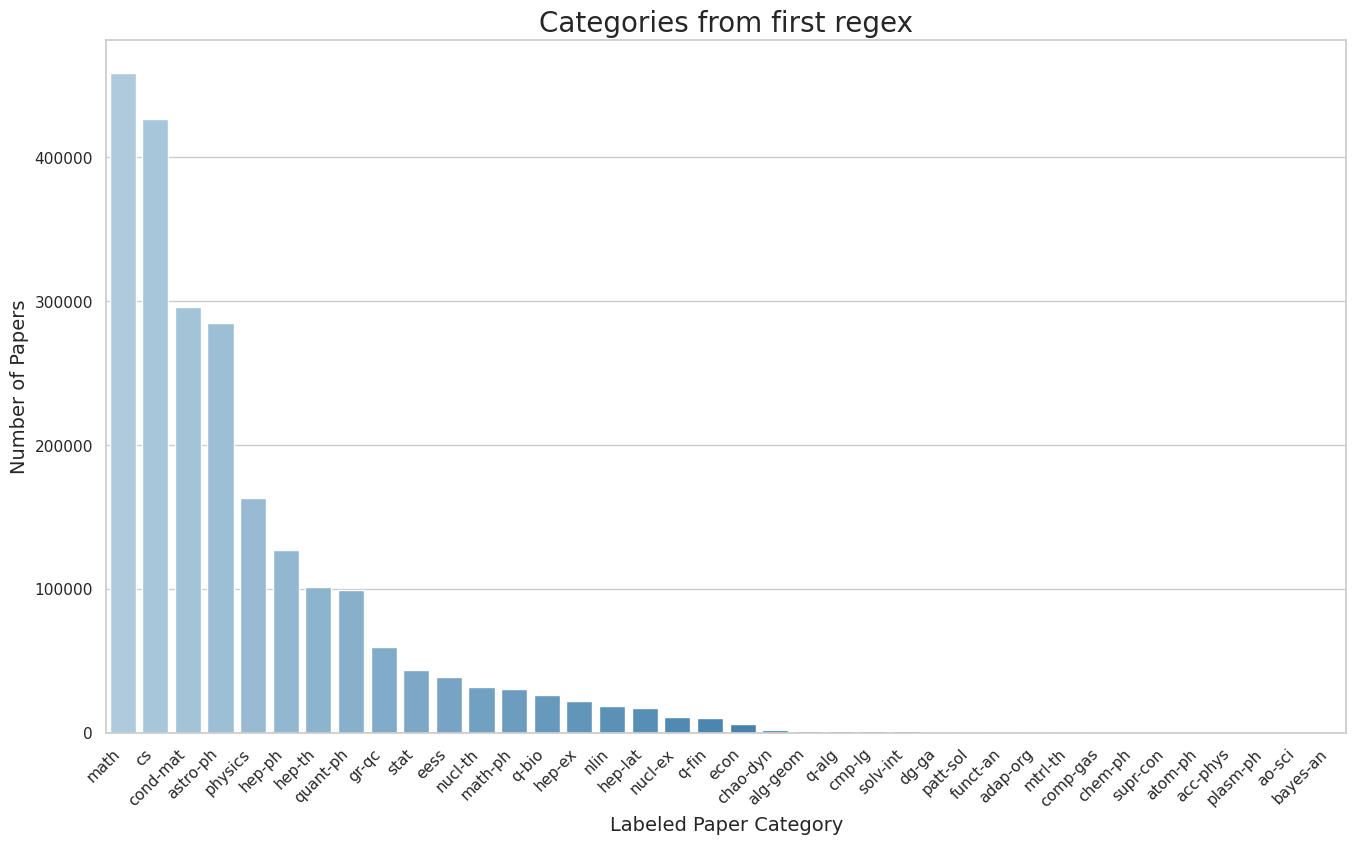

In [9]:
category_count = df['category'].value_counts()
xlabels = category_count.sort_values(ascending = False).index.to_list()
counts = category_count.sort_values(ascending = False).values
figure = pd.DataFrame({'labels':xlabels,'counts':counts}) 
plt.figure(figsize=(16, 9))
sns.set_theme(style="whitegrid")
sns.barplot( x = 'labels', y = 'counts', data = figure,
                 palette="Blues_d")
plt.xticks(rotation= 45, ha = 'right')
plt.title('Categories from first regex', fontsize=20)
plt.ylabel('Number of Papers', fontsize=14)
plt.xlabel('Labeled Paper Category', fontsize=14)

plt.savefig('Categories from first regex.png')

plt.show()

In [10]:
print(f"Number_of_categories: {len(category_count)}")

Number_of_categories: 38


We the first round of regex we noticed that there are some patterns that have not been captured:

- chao-dyn nlin.CD
- chao-dyn cond-mat.stat-mech nlin.CD
- alg-geom math.AG
- q-alg math.QA
- cmp-lg cs.CL
- solv-int nlin.SI

In [11]:
print(f"Null values: {df['mapped_categories'].isnull().sum()}")

Null values: 8203


In [12]:
# extracting rows with a null mapped category from the main dataset 
subset_null = df[df['mapped_categories'].isnull()]
# droppping the same rows from the main dataset 
df = df.dropna(subset=['mapped_categories'])

# regular expression to extract only the primary categories
subset_null = subset_null.drop(['category', 'mapped_categories'], axis=1)
subset_null['category'] = subset_null['categories'].str.extract(r'(?:.*?\s)?([^.\s]+)\.')
subset_null['mapped_categories'] = subset_null['category'].map(category_map)

In [13]:
# now there are no more null values in the df subset
print(f"Null values after the final regex: {subset_null['mapped_categories'].isnull().sum()}")

Null values after the final regex: 0


In [14]:
df = pd.concat([df, subset_null], ignore_index=True)

In [15]:
df.tail()

,categories,abstract,title,category,mapped_categories
2276606,supr-con cond-mat.supr-con,We report on measurements of the angular dep...,On the origin of the irreversibility line in t...,cond-mat,Electrical Engineering and Systems Science
2276607,supr-con cond-mat.supr-con,The non-linear microwave surface impedance o...,Nonlinear Response of HTSC Thin Film Microwave...,cond-mat,Electrical Engineering and Systems Science
2276608,supr-con cond-mat.supr-con,The vortex contribution to the dc field (H) ...,Critical State Flux Penetration and Linear Mic...,cond-mat,Electrical Engineering and Systems Science
2276609,supr-con cond-mat.supr-con,We show that the density of states in an ani...,Density of States and NMR Relaxation Rate in A...,cond-mat,Electrical Engineering and Systems Science
2276610,supr-con cond-mat.supr-con,The Ginzburg Landau theory for d_{x^2-y^2}-w...,Ginzburg Landau theory for d-wave pairing and ...,cond-mat,Electrical Engineering and Systems Science


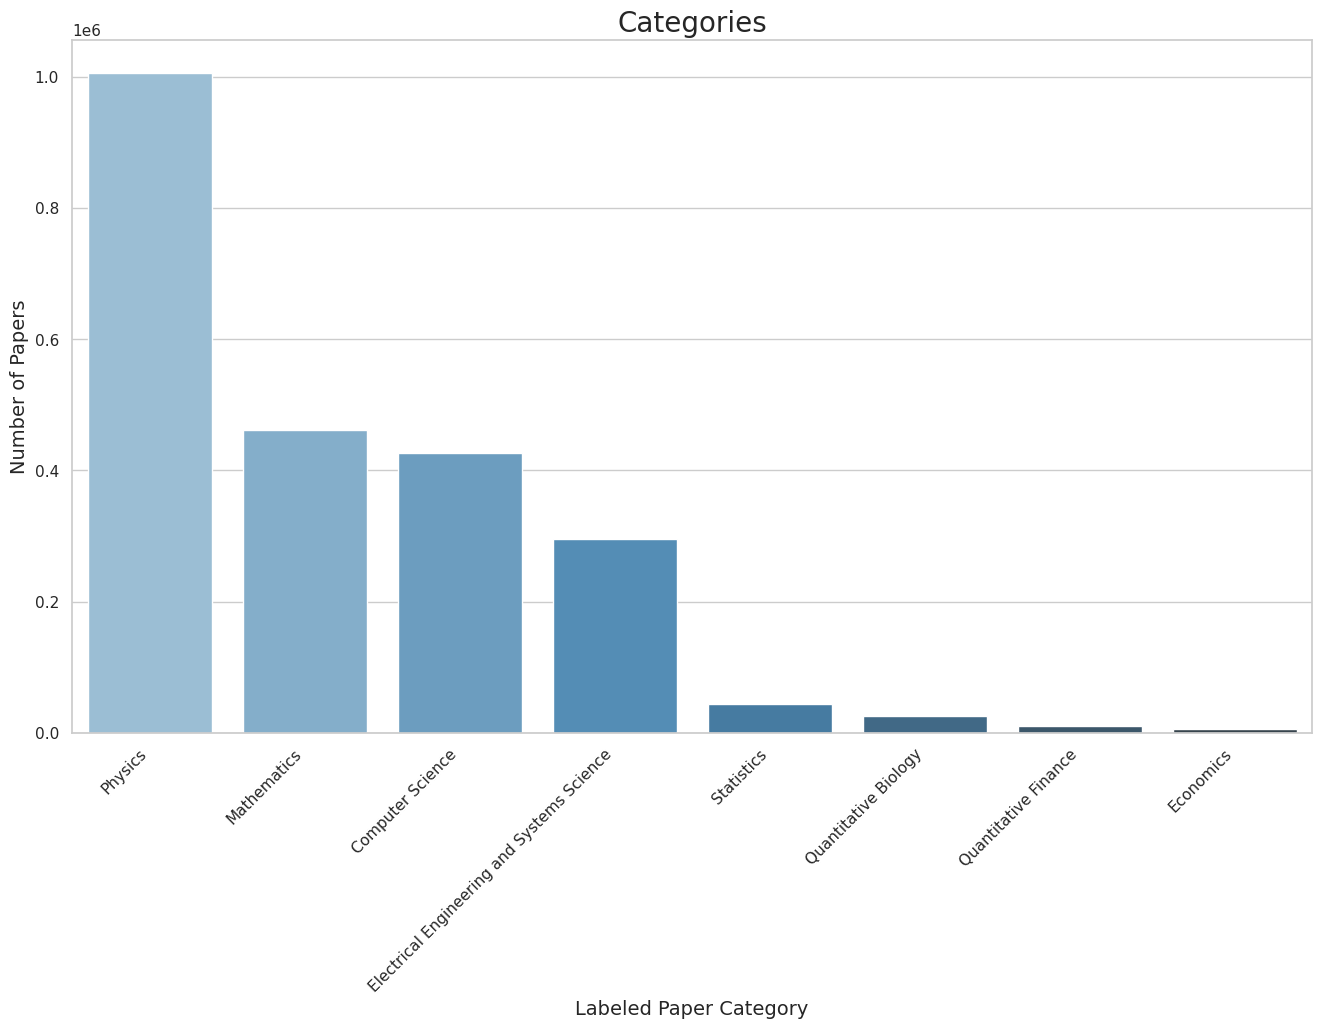

In [16]:
category_count = df['mapped_categories'].value_counts()
xlabels = category_count.sort_values(ascending = False).index.to_list()
counts = category_count.sort_values(ascending = False).values
figure = pd.DataFrame({'labels':xlabels,'counts':counts}) 
plt.figure(figsize=(16, 9))
sns.set_theme(style="whitegrid")
sns.barplot( x = 'labels', y = 'counts', data = figure,
                 palette="Blues_d")
plt.xticks(rotation= 45, ha = 'right')
plt.title('Categories', fontsize=20)
plt.ylabel('Number of Papers', fontsize=14)
plt.xlabel('Labeled Paper Category', fontsize=14)

plt.savefig('Categories.png')

plt.show()

In [17]:
df.head()

,categories,abstract,title,category,mapped_categories
0,hep-ph,A fully differential calculation in perturba...,Calculation of prompt diphoton production cros...,hep-ph,Physics
1,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...",Sparsity-certifying Graph Decompositions,math,Mathematics
2,physics.gen-ph,The evolution of Earth-Moon system is descri...,The evolution of the Earth-Moon system based o...,physics,Physics
3,math.CO,We show that a determinant of Stirling cycle...,A determinant of Stirling cycle numbers counts...,math,Mathematics
4,math.CA math.FA,In this paper we show how to compute the $\L...,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math,Mathematics


In [18]:
# assign a numeric value for every category
my_dict = {}
for i, item in enumerate(df['mapped_categories'].unique()):
    my_dict[item] = i

In [19]:
df['labels'] = df['mapped_categories'].map(my_dict)
df.head()

,categories,abstract,title,category,mapped_categories,labels
0,hep-ph,A fully differential calculation in perturba...,Calculation of prompt diphoton production cros...,hep-ph,Physics,0
1,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...",Sparsity-certifying Graph Decompositions,math,Mathematics,1
2,physics.gen-ph,The evolution of Earth-Moon system is descri...,The evolution of the Earth-Moon system based o...,physics,Physics,0
3,math.CO,We show that a determinant of Stirling cycle...,A determinant of Stirling cycle numbers counts...,math,Mathematics,1
4,math.CA math.FA,In this paper we show how to compute the $\L...,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math,Mathematics,1


## Undersampling the train set 

Since we had problems with the dataset's size we decided to undersample it. Before using the *Undersample* function we plitted the dataset in order to maintain an imbalanced test set.


In [20]:
X = df[['abstract', 'title', 'mapped_categories']]
y = df['labels']

In [21]:
X.shape

(2276611, 3)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.011) 

In [23]:
ros = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [24]:
train_resampled = pd.DataFrame({'abstract' : [x for x in X_resampled['abstract'].values],
                                'mapped_categories' : [x for x in X_resampled['mapped_categories'].values],
                                'title' : [x for x in X_resampled['title'].values],
                                'labels': [y for y in y_resampled]})

test = pd.DataFrame({'abstract' : [x for x in X_test['abstract'].values],
                     'mapped_categories' : [x for x in X_test['mapped_categories'].values],
                     'title' : [x for x in X_test['title'].values],
                    'labels': [y for y in y_test]})

In [25]:
print(f"Train portion: {train_resampled.shape[0] / (train_resampled.shape[0] + test.shape[0])}")

Train portion: 0.6397468172336905


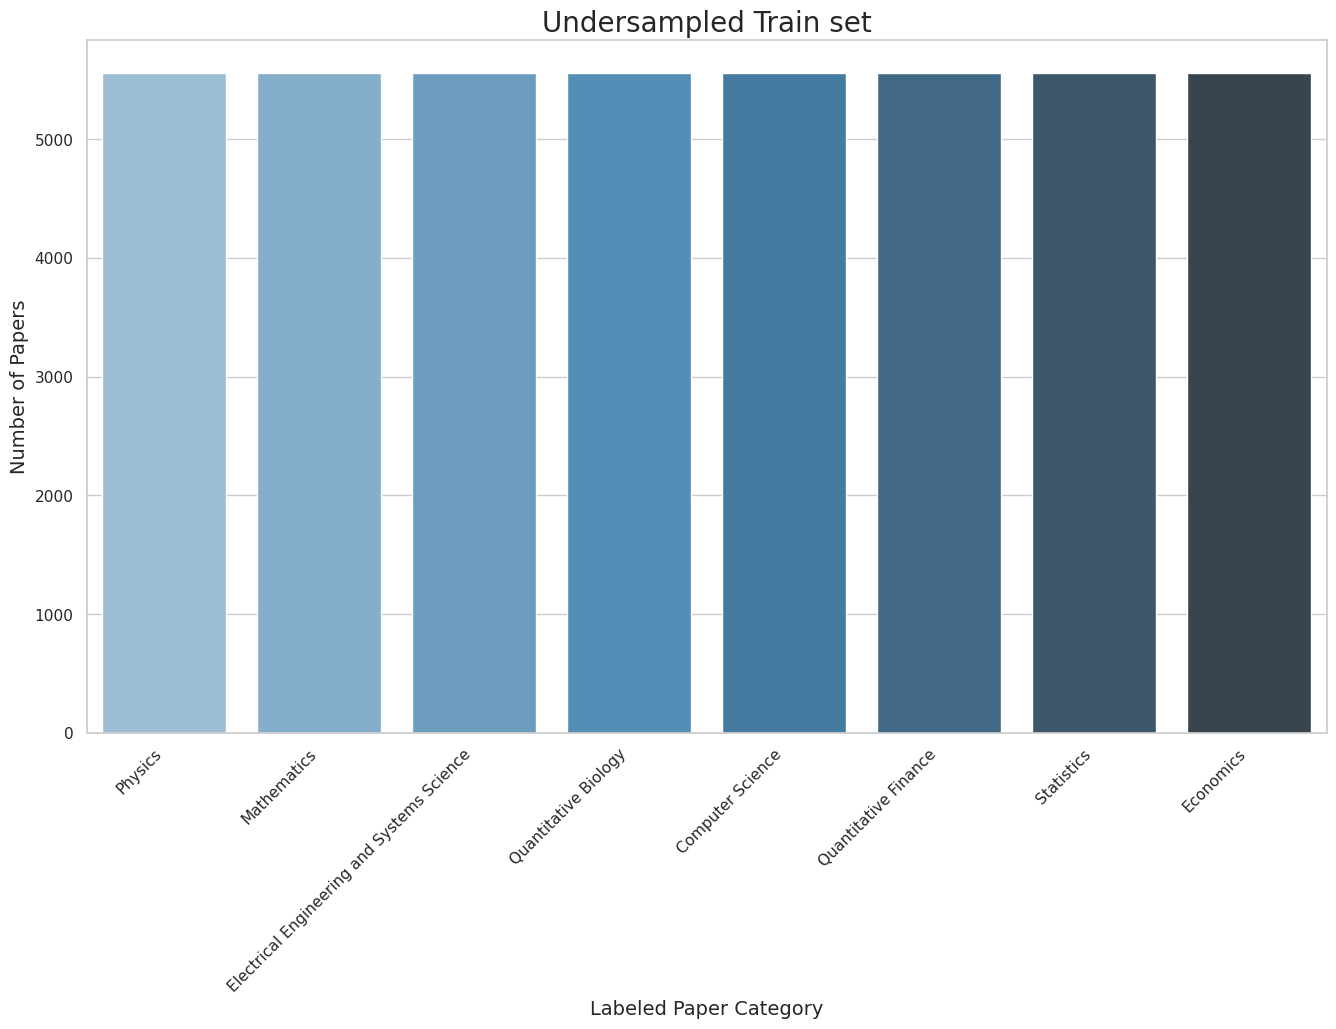

In [26]:
train_resampled_count = train_resampled['mapped_categories'].value_counts()
xlabels = train_resampled_count.sort_values(ascending = False).index.to_list()
counts = train_resampled_count.sort_values(ascending = False).values
figure = pd.DataFrame({'labels':xlabels,'counts':counts}) 
plt.figure(figsize=(16, 9))
sns.set_theme(style="whitegrid")
sns.barplot( x = 'labels', y = 'counts', data = figure,
                 palette="Blues_d")
plt.xticks(rotation= 45, ha = 'right')
plt.title('Undersampled Train set', fontsize=20)
plt.ylabel('Number of Papers', fontsize=14)
plt.xlabel('Labeled Paper Category', fontsize=14)

plt.savefig('Undersampled Train set.png')

plt.show()

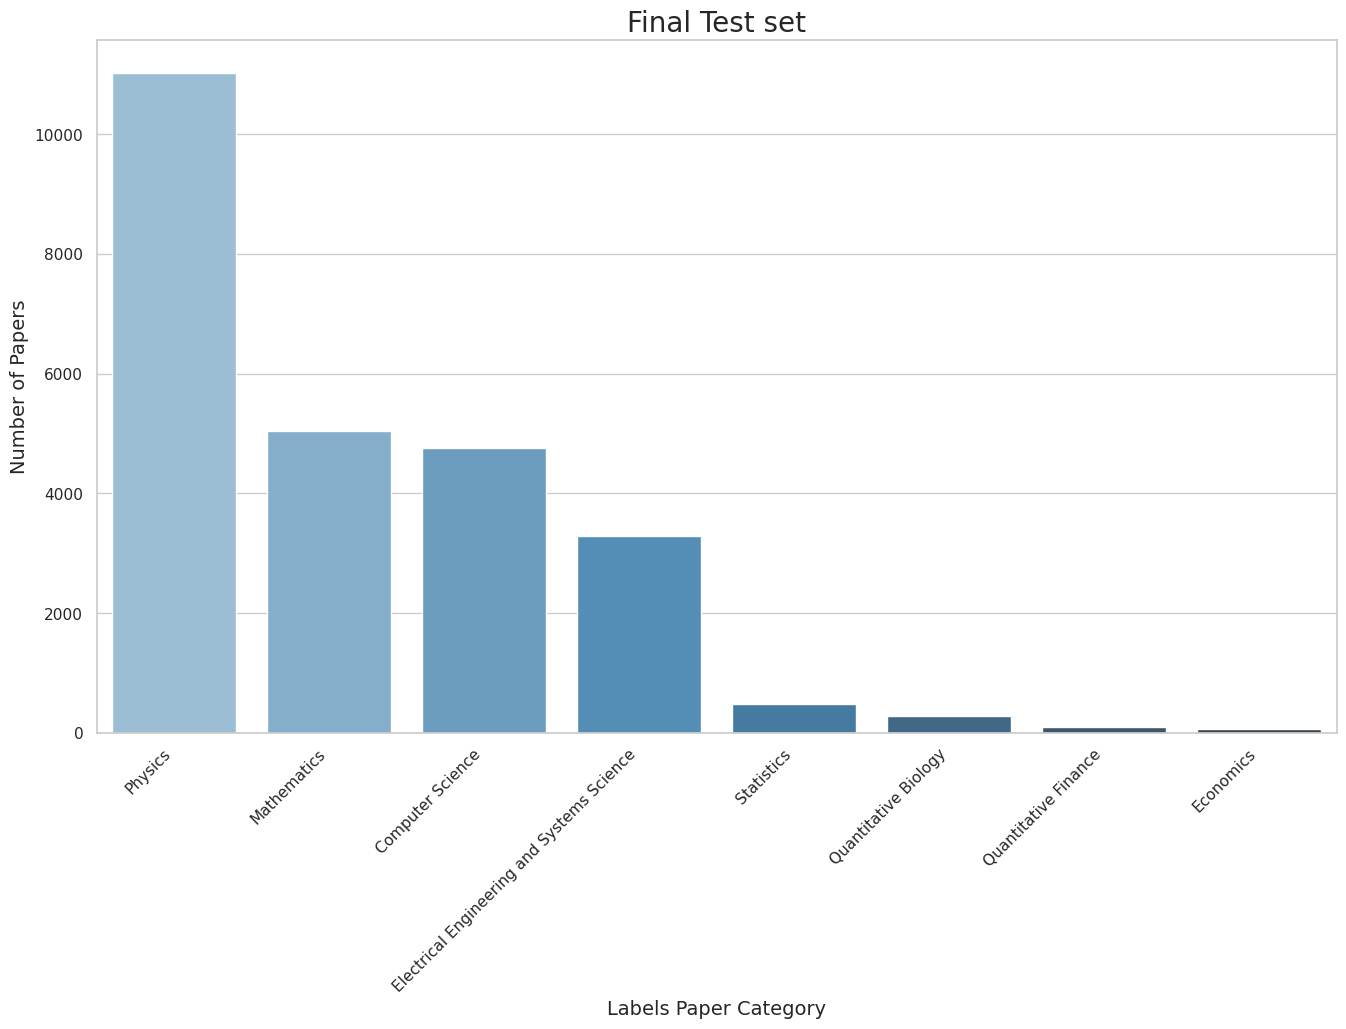

In [27]:
figure = pd.DataFrame(test.mapped_categories.value_counts()).reset_index()

figure = figure.rename(columns={'index': 'labels',
                               'mapped_categories': 'count'})

plt.figure(figsize=(16, 9))
sns.set_theme(style="whitegrid")
sns.barplot(x='labels', y='count', data=figure, palette="Blues_d")
plt.xticks(rotation=45, ha='right')
plt.title('Final Test set', fontsize=20)
plt.ylabel('Number of Papers', fontsize=14)
plt.xlabel('Labels Paper Category', fontsize=14)

plt.savefig('Final_Test_set.png')

plt.show()

## Shuffle the data
#### Train

In [28]:
rng = np.random.default_rng(seed=42)
shuffler1 = rng.permutation(train_resampled.shape[0])

In [29]:
X_train = train_resampled['abstract'].values
X_train = [X_train[i] for i in shuffler1]

y_train = train_resampled['labels'].values
y_train = [y_train[i] for i in shuffler1]

labels_train = train_resampled['mapped_categories'].values
labels_train = [labels_train[i] for i in shuffler1]

#### Test

In [30]:
shuffler2 = rng.permutation(test.shape[0])

In [31]:
X_test = test['abstract'].values
X_test = [X_test[i] for i in shuffler2]

y_test = test['labels'].values
y_test = [y_test[i] for i in shuffler2]

labels_test = test['mapped_categories'].values
labels_test = [labels_test[i] for i in shuffler2]

## Text Representation <a class="anchor" id="Text-representation"></a>

We transformed the textual data into numerical representations using TF-IDF (Term Frequency-Inverse Document Frequency) and Bag of Words approaches.

### Tf-idf

In [32]:
#data representation using TfidfVectorizer() as vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=4000, use_idf=True)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
print(f'''X_train_tfidf shape: {X_train_tfidf.shape}''')
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f'''X_test_tfidf shape: {X_test_tfidf.shape}''')

tf_len = len(tfidf_vectorizer.vocabulary_)

X_train_tfidf shape: (44472, 4000)
X_test_tfidf shape: (25043, 4000)


### Bag of Words

In [33]:
BOW_vectorizer = CountVectorizer(max_features=30000)

X_train_BOW = BOW_vectorizer.fit_transform(X_train)
print(f'''X_train_BOW shape: {X_train_BOW.shape}''')
X_test_BOW = BOW_vectorizer.transform(X_test)
print(f'''X_test_BOW shape: {X_test_BOW.shape}''')

X_train_BOW shape: (44472, 30000)
X_test_BOW shape: (25043, 30000)


#### Plots

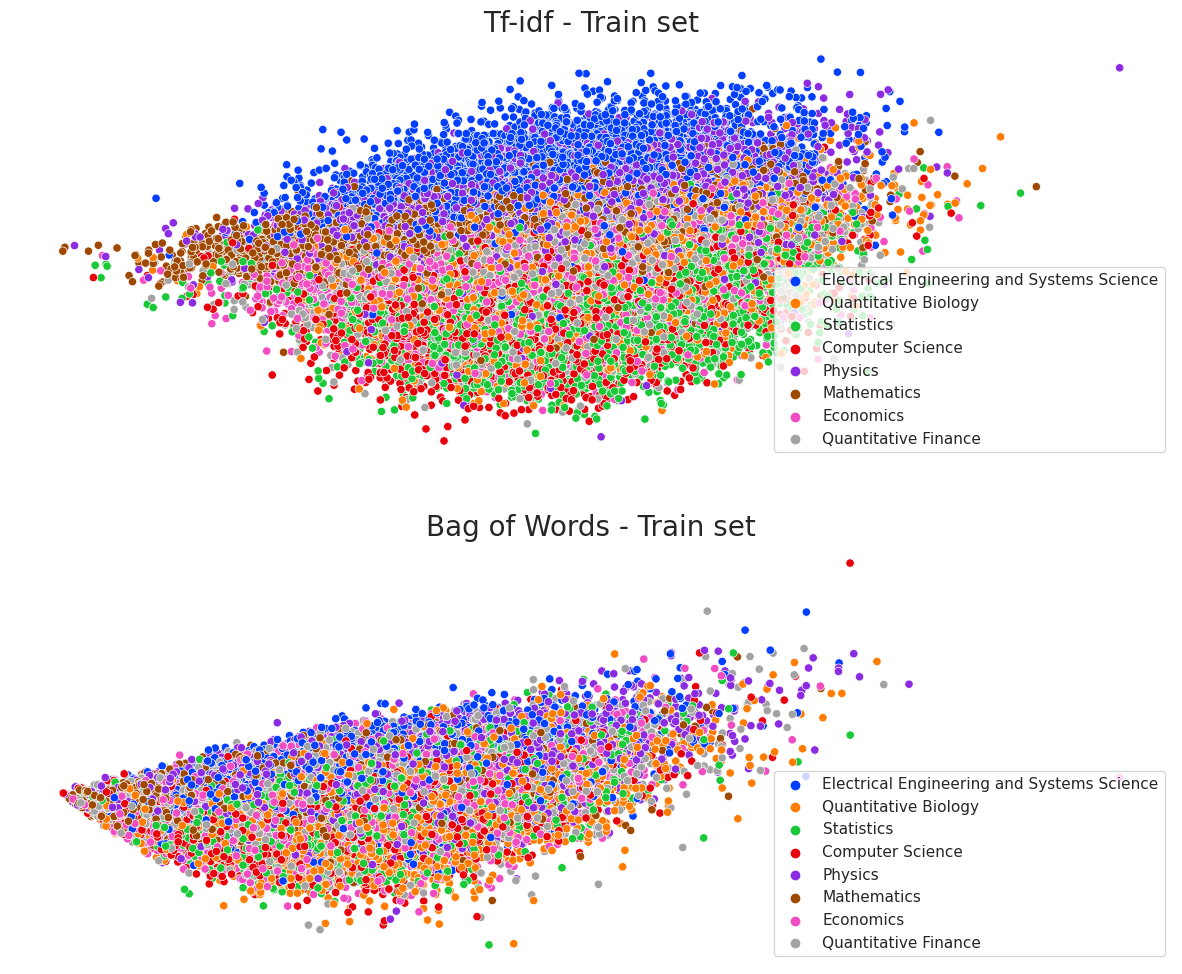

In [34]:
# Train set - Tf-idf
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
svd = TruncatedSVD(n_components=2)
data = svd.fit_transform(X_train_tfidf) 
scatter_x = data[:, 0]
scatter_y = data[:, 1]
sns.scatterplot(x=scatter_x, y=scatter_y, hue=labels_train, palette='bright', legend=True)
plt.title("Tf-idf - Train set", fontsize=20)
plt.axis('off')

# Train set - BOW
plt.subplot(2, 1, 2)
svd = TruncatedSVD(n_components=2)
data = svd.fit_transform(X_train_BOW) 
scatter_x = data[:, 0]
scatter_y = data[:, 1]
sns.scatterplot(x=scatter_x, y=scatter_y, hue=labels_train, palette='bright', legend=True)
plt.title("Bag of Words - Train set", fontsize=20)
plt.axis('off')

plt.savefig('representation.png')

plt.show()